# Imports

In [2]:
## Custom Imports
from polysaccharide.molutils import reactions
from polysaccharide.molutils.rdmol import rdconvert, rdlabels

from polysaccharide.polymer import monomer as monoutils
from polysaccharide.polymer.monomer import MonomerInfo

## Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    force=True
)

## Numeric imports
import pandas as pd

## File I/O
from pathlib import Path
import json

## Cheminformatics
from rdkit import Chem

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

# Param input

In [3]:
mono_data_path : Path = Path('processed_monomer_data') / 'clean_smarts_digroup.csv'
rxn_mech_dir   : Path = Path('rxn_smarts')
mono_info_dir  : Path = Path('monomer_files')

rxns_from_smarts : bool = True#False

## Load processed monomer starting structures

In [6]:
logging.info(f'Loading processed data from {mono_data_path.stem}')
digroup_table = pd.read_csv(mono_data_path, index_col=[0])
tables_by_chem = {
    chemistry : digroup_table[digroup_table['Chemistry'] == chemistry].dropna(axis=1).reset_index(drop=True)
        for chemistry in set(digroup_table['Chemistry'])
}

2023-08-18 14:16:13.529 [INFO    :       983503795:line 1  ] - Loading processed data from clean_smarts_digroup


## Load rxn mechanisms

In [4]:
reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

logging.info(f'Loading reaction mechanisms (from {"SMARTS" if rxns_from_smarts else "MDL files"})')
if rxns_from_smarts:
    with (rxn_mech_dir / 'rxn_smarts.json').open('r') as rxn_file:
        rxns = {
            chemistry : reactions.AnnotatedReaction.from_smarts(rxn_SMARTS)
                for chemistry, rxn_SMARTS in json.load(rxn_file).items()
        }
else:
    # from files
    rxns = {
        chemistry : reactions.AnnotatedReaction.from_rxnfile(rxn_mech_dir / f'{chemistry}.rxn')
            for chemistry in reaction_pairs.keys()
    }

2023-08-18 14:15:17.090 [INFO    :      1140903876:line 6  ] - Loading reaction mechanisms (from SMARTS)


# Polymerizing fragments

## Example for polymerization of individual molecule

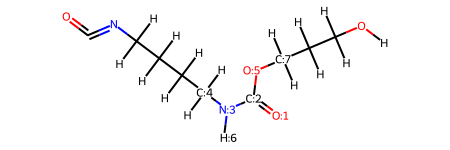

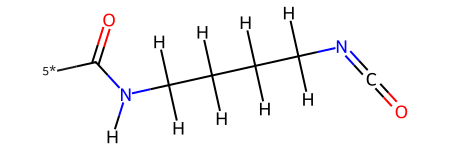

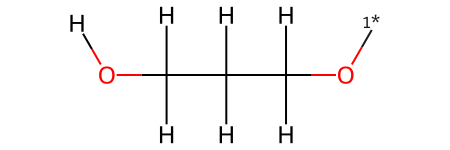

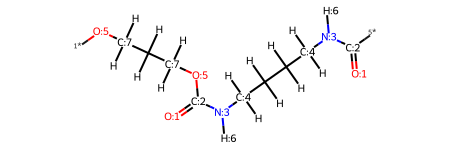

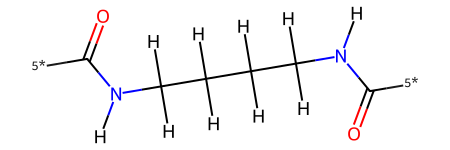

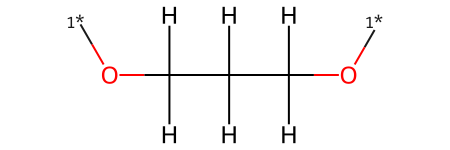

In [26]:
chemistry = 'urethane'
idx = 3

rxn_pathway = rxns[chemistry]
chem_tab = tables_by_chem[chemistry]
chem_entry = chem_tab.loc[idx]

reactants = {
    react_name : Chem.MolFromSmarts(chem_entry[react_name])
        for react_name in reaction_pairs[chemistry]
}

reactor = reactions.PolymerizationReactor(rxn_pathway)
for (dimer, pair) in reactor.propagate([i for i in reactants.values()]):
    display(dimer)
    for frag in pair:
        display(frag)
    print('='*50)

In [18]:
reactants.values()

dict_values([<rdkit.Chem.rdchem.Mol object at 0x7f45e88ef3e0>, <rdkit.Chem.rdchem.Mol object at 0x7f45e88eff40>])

In [16]:
chem_tab['hydroxyl']

0     [#8](-[#6](-[#6](-[#8]-[#6]1=[#6](-[#6](=[#6](...
1     [#6](-[#7](-[#6](-[H])(-[H])-[H])-[#6](-[#6](-...
2     [#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#8]...
3     [#8](-[#6](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-...
4     [#8]=[#15](-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]...
                            ...                        
58    [#8](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#8]...
59    [#8](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-[H])-[...
60    [#8](-[#6](-[#6](-[#6](-[#6](-[#8]-[H])(-[H])-...
61    [#8](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-[H])-[...
62    [#8](-[#6](-[#6]1(-[#6](-[#6](-[#6](-[#6](-[#8...
Name: hydroxyl, Length: 63, dtype: object

In [13]:
reaction_pairs[chemistry]

('isocyanate', 'hydroxyl')

## Polymerize all SMILES into well-specified fragments with ports

In [ ]:
mono_info_dir.mkdir(exist_ok=True)
cvtr = rdconvert.SMILESConverter()

for chemistry, smarts_table in tables_by_chem.items():
    chem_dir = mono_info_dir / chemistry
    chem_dir.mkdir(exist_ok=True)

    for i, sample in smarts_table.iterrows():
        logging.info(f'Generating fragments for {chemistry} #{i}')
        # look up reactive groups and pathway by chemistry
        rxn_group_names = reaction_pairs[chemistry]
        rxn = rxns[chemistry]

        # read reactant monomers from digroup_table
        initial_reactants = []
        for j, group_name in enumerate(rxn_group_names):
            reactant = Chem.MolFromSmarts(sample[group_name])
            for atom in reactant.GetAtoms():
                atom.SetProp('reactant_group', group_name)
            
            initial_reactants.append(reactant)
        mono_info = MonomerInfo()

        # first round of polymerization (initiation)
        reactor = reactions.PolymerizationReactor(rxn)
        for dimer, frags in reactor.propagate(initial_reactants):
            for assoc_group_name, rdfragment in zip(rxn_group_names, frags):
                rdfragment = cvtr.convert(rdfragment) # hacky workaround for RDKit nitrogen bond order SMARTS bug
                rdlabels.clear_atom_isotopes(rdfragment, in_place=True)

                affix = 'TERM' if monoutils.is_term_by_rdmol(rdfragment) else 'MID'
                mono_info.monomers[f'{assoc_group_name}_{affix}'] = Chem.MolToSmarts(rdfragment)

        # monomer post-processing and saving
        for monomer_tag, smarts in mono_info.monomers.items():
            monomer = Chem.MolFromSmarts(smarts)
            monomer = cvtr.convert(monomer) # must convert to-and-from SMILES (since SMARTS-Mols aren't be Kekulized properly)
            Chem.SanitizeMol(monomer) # need to Sanitize, otherwise Kekulize raises unexpected valence errors (despite valence never changing)
            
            Chem.Kekulize(monomer, clearAromaticFlags=True) # convert aromatic bonds to single-double
            rdlabels.assign_ordered_atom_map_nums(monomer, in_place=True) # number monomers

            mono_info.monomers[monomer_tag] = Chem.MolToSmarts(monomer).replace('#0', '*') # ensure wild atoms are marked correctly (rather than as undefined atoms)
        mono_info.to_file(chem_dir / f'{chemistry}_{i}.json')